In [86]:
import numpy as np
from pyomo.opt import SolverFactory
# import gurobipy

import pandas as pd
import scipy.optimize as so

import matplotlib.pyplot as plt

import pyomo.environ as pyo

import energym
from pyomo.opt import SolverStatus, TerminationCondition

import gurobipy as gp
from gurobipy import GRB

In [87]:
weather = "CH_VD_Lausanne"
env = energym.make("SimpleHouseRad-v0", weather=weather, simulation_days=6)

outputs = env.get_output()
outputs["temRoo.T"]

# for generating training data
steps = 288*5
out_list = []
outputs = env.get_output()
controls = []
hour = 0
hours = []
for i in range(steps):
    control = {}
    control['u'] = [0.5*(np.sin(i * 0.1 + np.random.rand()) + 1)]
    controls +=[ {p:control[p][0] for p in control} ] # each element is a dictionary
    outputs = env.step(control)
    _,hour,_,_ = env.get_date()
    hours.append(hour)
    out_list.append(outputs)
    
    
out_df = pd.DataFrame(out_list)
in_df = pd.DataFrame(controls)

the initial variables are {'u': 0.0}
[OK] %s
[WARNING] %s


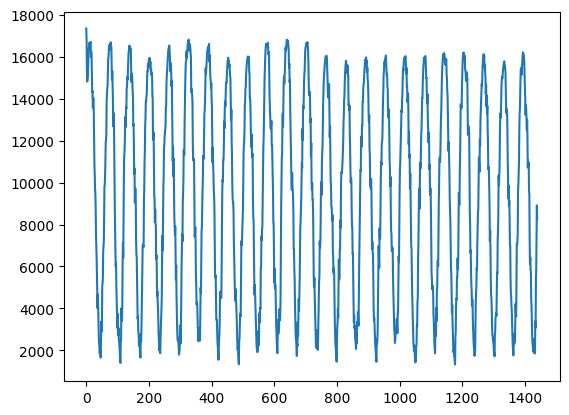

In [88]:
Inputs_index = ["TOut.T", "rad.Q_flow", "sunRad.y", "time"]
Inputs = out_df[Inputs_index]
Inputs

Outputs = out_df["y"].values
plt.plot(-out_df["rad.Q_flow"])

In [98]:
N = 24
d = np.append(out_df[["TOut.T", "sunRad.y"]].values[:N], np.ones((N,1))*2000, axis = 1)
d[:,0] -= 273.15
dbar = d.reshape(-1)
dbar

array([-7.63888889e-02,  0.00000000e+00,  2.00000000e+03, -1.38888889e-01,
        0.00000000e+00,  2.00000000e+03, -1.87500000e-01,  0.00000000e+00,
        2.00000000e+03, -2.22222222e-01,  0.00000000e+00,  2.00000000e+03,
       -2.43055556e-01,  0.00000000e+00,  2.00000000e+03, -2.50000000e-01,
        0.00000000e+00,  2.00000000e+03, -2.43055556e-01,  0.00000000e+00,
        2.00000000e+03, -2.22222222e-01,  0.00000000e+00,  2.00000000e+03,
       -1.87500000e-01,  0.00000000e+00,  2.00000000e+03, -1.38888889e-01,
        0.00000000e+00,  2.00000000e+03, -7.63888889e-02,  0.00000000e+00,
        2.00000000e+03,  0.00000000e+00,  0.00000000e+00,  2.00000000e+03,
        1.09375000e-01,  0.00000000e+00,  2.00000000e+03,  2.63888889e-01,
        0.00000000e+00,  2.00000000e+03,  4.53125000e-01,  0.00000000e+00,
        2.00000000e+03,  6.66666667e-01,  0.00000000e+00,  2.00000000e+03,
        8.94097222e-01,  0.00000000e+00,  2.00000000e+03,  1.12500000e+00,
        0.00000000e+00,  

In [99]:
# def predict_2R2C(x,inputs, output):
#     Ci, Ce, Rie, Reo, Ai = x
#     N = inputs.shape[0]
#     Ns = int(24*12)
#     seg_len = Ns

#     rad_Q = -inputs["rad.Q_flow"].values
#     to = inputs["TOut.T"].values - 273.15
#     sun_rad = inputs["sunRad.y"].values
#     time = inputs["time"].values

#     output = output - 273.15

#     dt = time = 300 ### time interval is 300 seconds
    

#     ti = np.zeros(N)
#     te = np.zeros(N)
    
#     for s in range(int(N/Ns)):
#         k = s*Ns
#         ti[k] = output[k]
#         te[k] = Rie/(Reo+Rie) *to[k] + Reo/(Reo + Rie)*ti[k] #(1 + Rir/Rio)*ti[k] - to[k]*(Rir/Rio)
#         for t in range(Ns-1):
#             ti[k+t+1] = ti[k+t] + dt/Ci * ( (te[k+t] - ti[k+t])/Rie + rad_Q[k+t])
#             te[k+t+1] = te[k+t] + dt/Ce * ( (ti[k+t] - te[k+t])/Rie + (to[k+t] - te[k+t])/Reo + Ai*sun_rad[k+t]) 
#     return ti

In [100]:
# def fun_2R2C(x, inputs, output): ###### Ci: indoor temp thermal capacity, Ce: envelop thermal capacity
    
#     Ci, Ce, Rie, Reo, Ai = x
#     N = inputs.shape[0]
#     Ns = int(24*12)
#     seg_len = Ns

#     rad_Q = -inputs["rad.Q_flow"].values
#     to = inputs["TOut.T"].values - 273.15
#     sun_rad = inputs["sunRad.y"].values
#     time = inputs["time"].values

#     output = output - 273.15

#     dt = time = 300 ### time interval is 300 seconds
    

#     ti = np.zeros(N)
#     te = np.zeros(N)
#     ti[0] = output[0]
#     te[0] = Rie/(Reo+Rie)*to[0] + Reo/(Reo + Rie)*ti[0] 
#     for s in range(int(N/Ns)):
#         k = s*Ns
#         ti[k] = output[k]
#         te[k] = Rie/(Reo+Rie) *to[k] + Reo/(Reo + Rie)*ti[k] #(1 + Rir/Rio)*ti[k] - to[k]*(Rir/Rio)
#         for t in range(Ns-1):
#             ti[k+t+1] = ti[k+t] + dt/Ci * ( (te[k+t] - ti[k+t])/Rie + rad_Q[k+t])
#             te[k+t+1] = te[k+t] + dt/Ce * ( (ti[k+t] - te[k+t])/Rie + (to[k+t] - te[k+t])/Reo + Ai*sun_rad[k+t])            
            
#     return sum( (ti[t] - output[t])**2 for t in range(N))

In [101]:
# res_2r2c = so.differential_evolution(func = fun_2R2C, x0 = (9.2e6,1e8,2e-3,2e-5,4.8e2), args = (Inputs, Outputs), bounds = [(1e6, 1e7),(1e6,1e9),(1e-4,1e-2),\
#                                                                                                    (1e-6,1e-4),(1e-6,1e-4)])
# p_fun_2r2c = res_2r2c.x
# print("optimal value found by 2R2C: ", p_fun_2r2c)

In [102]:
# pred_2r2c = predict_2R2C(p_fun_2r2c, Inputs, Outputs)
# plt.plot(pred_2r2c, "b")
# plt.plot(Outputs - 273.15, "r")

In [103]:
dim = 2

Ci, Ce, Rie, Reo,  Ai = 9.28479953e+06, 1.00000000e+08, 2.01584186e-03, 1.99362226e-05, 4.85915263e+02

dt = 300
### A's shape is (2,2), B's shape is (2,1), and R's shape is (2,3)
A11 = 1 - dt/(Ci*Rie)
A12 = dt/(Ci*Rie)
A21 = dt/(Ce*Rie)
A22 = 1 - dt/Ce * (1/Rie + 1/Reo)

B1 = dt/Ci*5

R11 = 0
R12 = 0
R21 = dt/(Ce*Reo) ### outdoor temp
R22 = dt/Ce*Ai ### solar irradiation
A = np.array([[A11, A12],
             [A21, A22]])
B = np.array([[B1],
             [0]])
R = np.array([[R11, R12, 0],
             [R21, R22, 0]])



# A = np.array([[0.98834642]])
# B = np.array([[9.17224643e-05]])
# R = np.array([[0.01165358, 0.00012355]])


n = 2
p = 1  ### size of input from grid
q = 1  ### size of input from solar
m = 3  ### size of uncertainty

# N = 24 ### length of prediction horizon

In [104]:
def lifted_matrix(A,B,n,m,N):
    P = np.zeros((n*(N),m*N))
    for i in range(N):
        for j in range(N):
            if j > i:
                Pij = np.zeros((n,m))
            else:
                Pij = np.dot(np.linalg.matrix_power(A,i-j),B)
            P[i*n:(i+1)*n, j*m:(j+1)*m] = Pij
    return P
    
####  X = Fx0 + Fu*u + Fv*v + Fw*d,  d is uncertainty            
def time_lifted_matrix(N):
    Fu = np.zeros((n*N, p*N))
    Fw = np.zeros((n*N, m*N))
    Fv = np.zeros((n*N, q*N))

    Fu = lifted_matrix(A,B,n,p,N)
    Fv = lifted_matrix(A,B,n,q,N)


    Fw = lifted_matrix(A,R,n,m,N)
    
    return Fu, Fv, Fw

Fx = np.zeros((N*n,n))

for t in range(N):
    Fx[t*n:(t+1)*n, :] = np.linalg.matrix_power(A,t+1)


#### Fr and Fv are scaled so that the reference input can be binary ####
Fu, Fv, Fw = time_lifted_matrix(N)

x0 = np.array([21,22]) 
Fx0 = Fx@x0

dbar_diag = np.diag(dbar)

In [105]:
##### indoor temp constraints
Gx = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N),np.array([[1,0]])))

T_high = 24
T_low = 19
gx = np.kron(np.array([T_high, -T_low]), np.ones(N))
##### total input constraints
Gu = np.kron(np.array([[1],[-1]]), np.eye(N))

U_high = 10e4*np.ones(N)### total maximal power input
gu = np.concatenate((U_high*np.ones(N), np.zeros(N)))
##### availability of RES
Gv = np.kron(np.array([[1],[-1]]), np.eye(N))

vbar = 2000*np.ones(N)## availability of local RES  需要修改！！！
gv = np.concatenate((vbar, np.zeros(N)))


In [106]:
trans_mat = -np.kron(np.eye(N), np.array([[0,0,0],[0,1,0],[0,0,1]])) 
dbar_trans = trans_mat@dbar_diag + np.kron(np.eye(N), np.array([[1,0,0],[0,0,0],[0,0,0]]))

In [152]:
####################### temperature constraints #######################
T1 = Gx@Fu
W1 = Gx@Fv
M1 = Gx@Fw@dbar_trans
h1 = gx - Gx@(Fw@dbar + Fx0) ### gx is the upper and lower bounds of indoor temperature

####################### physical constraints of HP ######################
T2 = Gu
W2 = Gv
M2 = np.zeros(shape = (2*N, 3*N))
h2 = gu ### gu is the vector constructed from the upper and lower bounds of total inputs

######################## RES availability constraints #####################
T3 = np.zeros(shape = (2*N,N))
W3 = Gv
M3 = np.concatenate( (np.kron(np.eye(N), np.array([[0,0,1]]))@dbar_diag, np.zeros((N,3*N)) ), axis = 0)  ###np.zeros(shape = (2*N, 3*N))
h3 = gv

T = np.concatenate((T1,T2,T3), axis = 0)
W = np.concatenate((W1,W2,W3), axis = 0)
M = np.concatenate((M1,M2,M3), axis = 0)

h = np.concatenate((h1,h2,h3), axis = 0)

c = 0.01*np.ones(N) #np.array([])
b = 0.01*np.ones(N) #np.array([])

# D1 = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N), np.eye(3)))
# D2 = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N), np.eye(3)))
# D3 = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N), np.eye(3)))
# D4 = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N), np.eye(3)))

# d_high = np.array([1, 50, 2e2])
# d_low = np.array([-1,-50,-2e2])
# d1 = np.kron(np.array([1,-1]), np.kron(np.ones(N), d_high))
# # d2 = np.array([])
# # d3 = np.array([])
# # d4 = np.array([])
# d2 = d3 = d4 = d1

In [153]:
#### classes of different uncertainty set
#pbar = np.array([1,0,0,0]) ##1/kk*np.ones(kk)

uncer_sets = np.load(r"./Data_Driven_Uncertainty/uncer_set.npz")
D_set = uncer_sets["D_set"]
d_set = uncer_sets["d_set"]
pbar = uncer_sets["pbar"]
kk = len(D_set)
rho = 100
kk = len(D_set)

ind_k = range(kk)
ind_y = range(W.shape[1])
ind_T = range(T.shape[0])
ind_x = range(T.shape[1])
ind_u = range(M.shape[1])


scalar = 1
b = scalar*b
c = scalar*c

In [154]:
D_set[1].shape

(192, 72)

In [155]:
# def SP(x,D,d):
#     bigM1 = 1e3
#     sp = pyo.ConcreteModel()
#     sp.u = pyo.Var(ind_u, domain = pyo.Reals)
#     sp.y = pyo.Var(ind_y, domain = pyo.Reals)
#     sp.pi = pyo.Var(ind_T, domain = pyo.NonNegativeReals, initialize = 0)
#     sp.z = pyo.Var(ind_T, domain = pyo.Binary)
#     sp.e = pyo.Var(domain = pyo.Binary)
#     sp.vio = pyo.Var(domain = pyo.NonNegativeReals)
#     ucons_ind = range(D.shape[0])
    
#     bigM2 = bigM1
#     M_vio = bigM1
    
#     def vio_cons(m):
#         return M_vio - sum(m.pi[k] for k in ind_T) >= 0
    
#     sp.vio_cons = pyo.Constraint(rule = vio_cons)
    
#     def cons1(m,i):
#         return np.dot(T[i,:],x) + pyo.summation(W[i,:],m.y) + pyo.summation(M[i,:],m.u) <= h[i] + m.vio
    
#     sp.cons1 = pyo.Constraint(ind_T, rule = cons1)
    
#     def cons2(m,i):
#         return b[i] == - pyo.summation(W[:,i], m.pi)
    
#     sp.cons2 = pyo.Constraint(ind_y, rule = cons2)
    
#     def cons_bigM11(m,i):
#         return m.pi[i] <= bigM1*m.z[i]
    
#     def cons_bigM12(m,i):
#         return  np.dot(T[i,:],x) + pyo.summation(W[i,:], m.y) + pyo.summation(M[i,:],m.u) - h[i] - m.vio >= (m.z[i]-1)*bigM1
    
#     sp.cons_bigM11 = pyo.Constraint(ind_T, rule = cons_bigM11)
#     sp.cons_bigM12 = pyo.Constraint(ind_T, rule = cons_bigM12)
    
#     def cons_bigM211(m):
#         return (M_vio - sum(m.pi[i] for i in ind_T)) <= m.e*bigM2
#     def cons_bigM212(m):
#         return M_vio - sum(m.pi[i] for i in ind_T) >= 0
    
#     def cons_bigM22(m):
#         return m.vio <= (1-m.e)*bigM2
    
#     sp.cons_bigM211 = pyo.Constraint(rule = cons_bigM211)
#     sp.cons_bigM212 = pyo.Constraint(rule = cons_bigM212)
#     sp.cons_bigM22 = pyo.Constraint(rule = cons_bigM22)
    
#     def u_cons(m,i):
#         return pyo.summation(D[i,:], m.u) <= d[i]
    
#     sp.u_cons = pyo.Constraint(ucons_ind, rule = u_cons)
    
    
#     sp.Obj = pyo.Objective(expr = pyo.summation(b,sp.y) + M_vio*sp.vio, sense = pyo.maximize)

#     opt_sp = pyo.SolverFactory("gurobi")
# #    opt_sp =  pyo.SolverFactory("scip",executable = "C:\\Program Files\\SCIPOptSuite 8.1.0\\bin\\scip")
# #     opt_sp.options["timelimit"] = 300
# #     opt_sp.options["MIPGap"] = 1e-2
    
#     results = opt_sp.solve(sp)
    
#     return sp, results

In [156]:
import gurobipy as gp
from gurobipy import GRB

def SP_gp(x,D,d):
    bigM1 = 1e5
    m = gp.Model("sp")
    u = m.addMVar(shape = (len(ind_u),), vtype = GRB.CONTINUOUS)
    y = m.addMVar(shape = (len(ind_y),), vtype = GRB.CONTINUOUS)
    pi = m.addMVar(shape = (len(ind_T),), vtype = GRB.CONTINUOUS, lb = 0)
    z = m.addMVar(shape = (len(ind_T),), vtype = GRB.BINARY)
    e = m.addVar(vtype = GRB.BINARY)
    vio = m.addVar(vtype = GRB.CONTINUOUS, lb = 0)

    
    # sp.u = pyo.Var(ind_u, domain = pyo.Reals)
    # sp.y = pyo.Var(ind_y, domain = pyo.Reals)
    # sp.pi = pyo.Var(ind_T, domain = pyo.NonNegativeReals, initialize = 0)
    # sp.z = pyo.Var(ind_T, domain = pyo.Binary)
    # sp.e = pyo.Var(domain = pyo.Binary)
    # sp.vio = pyo.Var(domain = pyo.NonNegativeReals)
    ucons_ind = range(D.shape[0])
    
    bigM2 = 1e5
    M_vio = 1e5


    m.addConstr( sum(pi[k] for k in ind_T) <= M_vio )
    m.addConstrs( (np.dot(T[i,:],x) + W[i,:]@y + M[i,:]@u <= h[i] + vio for i in ind_T), name = "cons1")
    m.addConstrs( (W[:,i]@pi == -b[i] for i in ind_y), name = "cons2")
    m.addConstrs( (pi[i] <= bigM1*z[i] for i in ind_T), name = "bigM11" )
    m.addConstrs( (np.dot(T[i,:],x) + W[i,:]@y + M[i,:]@u - h[i] - vio >= bigM1*(z[i]-1) for i in ind_T), name = "bigM12" )
    m.addConstr( M_vio - sum(pi[i] for i in ind_T) <= e*bigM2, name = "bigM211" )
    m.addConstr( M_vio - sum(pi[i] for i in ind_T) >= 0, name = "bigM212" )
    m.addConstr( vio <= (1-e)*bigM2, name = "bigM22" )
    m.addConstrs( (D[i,:]@u <= d[i] for i in ucons_ind) )

    m.setObjective(b@y + M_vio*vio, GRB.MAXIMIZE)

    m.setParam("OutputFlag", 0)
    m.optimize()

    return m.ObjVal, np.array(u.x), vio.x, m

In [157]:
def SP_sd(x,D,d):
    M_vio = 1e5
    ucons_ind = range(D.shape[0])
    
    m = gp.Model("sp")
    u = m.addMVar(len(ind_u), vtype = GRB.CONTINUOUS)
    pi = m.addMVar(len(ind_T), vtype = GRB.CONTINUOUS, lb = 0, ub = 1e8)
#    mu = m.addVar(vtype = GRB.CONTINUOUS, lb = 0)
    aug_var = m.addMVar(len(ind_T), vtype=GRB.CONTINUOUS, ub = 1e8)

    m.addConstrs( (T[i,:]@x + M[i,:]@u - h[i] == aug_var[i] for i in ind_T) )
    m.addConstrs( (-b[i] == W[:,i]@pi for i in ind_y) )
    m.addConstr( M_vio - sum(pi[t] for t in ind_T) >= 0 )

    m.addConstrs( (D[i,:]@u <= d[i] for i in ucons_ind) )
    m.setObjective(sum(pi[t]*aug_var[t] for t in ind_T))
    m.ModelSense = GRB.MAXIMIZE
    #m.setObjective(pi@aug_var, GRB.MAXIMIZE)

    m.setParam("OutputFlag", 0)
    m.Params.NonConvex = 2
    m.optimize()

    return m.ObjVal, np.array(u.x), 0, m

In [158]:
def MP_gp(u_set, iter_k):
    
    ########## u_set is the list of extreme scenarios for all past iterations  ##########
    mp = gp.Model("master")
    x = mp.addMVar(shape = (len(ind_x),), vtype = GRB.CONTINUOUS)
    
    y = mp.addMVar(shape = (iter_k+1, len(ind_y)*len(ind_k)), vtype = GRB.CONTINUOUS)
    theta = mp.addMVar(shape =(iter_k+1, len(ind_k)), vtype = GRB.CONTINUOUS )
    gamma = mp.addMVar(shape = (iter_k+1, len(ind_k)), vtype = GRB.CONTINUOUS, lb = 0)
    mu = mp.addVar(vtype = GRB.CONTINUOUS, name = "mu")
    mu.Start = 10
    nv = mp.addVar(vtype = GRB.CONTINUOUS, lb = 500, name = "nv")
    nv.Start = 500
    eta = mp.addVar(vtype = GRB.CONTINUOUS)
    
    
#    mp.addConstr(A@x >= q)
    
    
    for itr in range(iter_k+1):
        
        mp.addConstr(mu + rho*nv - eta + nv*(pbar@gamma[itr,:]) <= 0)

        for k in ind_k:
            mp.addGenConstrLog(gamma[itr,k], theta[itr,k])

            mp.addConstr(T@x + W@y[itr,k*len(ind_y):(k+1)*len(ind_y)]  <= h - M@u_set[itr][k])
            mp.addConstr((theta[itr,k]+1)*nv >= b@y[itr,k*len(ind_y):(k+1)*len(ind_y)] - mu)
            #mp.addConstr( (theta[itr,k]+1)*nv == sum(b[t]*y[itr,k*len(ind_y)+t] for t in ind_y) - mu)
        
        
    mp.setObjective(c@x + eta, GRB.MINIMIZE)
    mp.setParam("OutputFlag", 0)   
    mp.optimize()
    
    print("master problem termination condition: ", mp.status)
    x_value = x.x
    return np.array(x_value), mu.x, nv.x, mp # np.array(x.x), mu.x, nv.x, mp   
            
    
#u_set = [[np.array([0,0,0]),np.zeros(3),np.zeros(3),np.zeros(3)]]

#x, mu, nv, mp = MP_gp(u_set,0)    

In [159]:
u_set = [[np.zeros(3*N) for i in range(kk)]]

# D_set = [D1, D2, D3, D4]
# d_set = [d1, d2, d3, d4]

import time
ccg_str = time.time()

UB_list = np.array([])
LB_list = np.array([])

epsilon = 50
num_iter = 5
UB = 1e6
LB = -1e5
for k_iter in range(num_iter):
    
    mp_x, mp_mu, mp_nv, mp = MP_gp(u_set, k_iter)  #### solve master problem
    
    print("master problem termination condition: ", mp.status)
    
#    y = np.array([pyo.value(mp_subopt.y[k]) for k in range(1,len(mp_subopt.y)+1)]) #####  添加循环的上界
    
#    eta, mp_subopt_2 = MP_subopt2(y)
    
    LB = mp.ObjVal
    
    LB_list = np.append(LB_list, LB)
    
    x = mp_x
    
    sp_obj_vec = np.array([])
    u_set_iter = []
    sp_termination_status = []
    
    for k in ind_k:
        D, d = D_set[k], d_set[k]
        sp_obj, sp_u, sp_vio, sp = SP_gp(x, D, d)  ## solve k different subproblems 

        print("SP termination condition is: ", sp.status)
        u_k = sp_u #np.array([sp.u.x for i in ind_u])
#        print(results.solver.termination_condition)
#        u_k = np.array([pyo.value(sp.u[i]) for i in ind_u])
        u_set_iter.append(u_k)
        sp_termination_status.append(sp.status == 2)
#        sp_termination_status.append(results.solver.termination_condition == TerminationCondition.infeasibleOrUnbounded)
        
        #if results.solver.termination_condition != TerminationCondition.infeasibleOrUnbounded:
        if sp.status == 2:                   
#            sp_obj = pyo.value(sp_obj)             
            sp_obj_vec = np.append(sp_obj_vec, sp_obj)
            
    u_set.append(u_set_iter)
    print("subproblem solution: ", sp_obj_vec)
    print("subproblem termination condition: ", sp_termination_status)
#    print(results.solver.termination_condition)
    print("master problem nv is: ", mp_nv)
    print("master problem mu is: ", mp_mu)

    print("subproblem violation is: ", sp_vio)
#    print(pyo.value(sp.vio))
    if mp_nv == 0:
        UB_candidate = np.dot(c, x) + mp_mu + rho*mp_nv #+ mp_nv*( np.dot(pbar, 
                    #np.exp( (sp_obj_vec - mp_mu)/mp_nv -1 )) )
    else:
        UB_candidate = np.dot(c, x) + mp_mu + rho*mp_nv + mp_nv*( np.dot(pbar, 
                    np.exp( (sp_obj_vec - mp_mu)/mp_nv -1 )) )

    UB = min(UB, UB_candidate)
    UB_list = np.append(UB_list,UB)
    print("Lower bound is: ", LB)
    print("Upper bound is: ", UB)

            
    if np.abs(UB - LB) <= epsilon:
        print("first stage decision variables: ", x)
        print("worst case scenario is: ", u_set)
        break

computation_time_ccg = time.time() - ccg_str
print("computation time of ccg is: ", computation_time_ccg)

master problem termination condition:  2
master problem termination condition:  2
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
SP termination condition is:  2
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
SP termination condition is:  2
subproblem solution:  [3564.36610715  159.93443004]
subproblem termination condition:  [True, True]
master problem nv is:  10.0
master problem mu is:  84.30970003456581
subproblem violation is:  0.0
Lower bound is:  1197.5141079437012
Upper bound is:  1000000.0
master problem termination condition:  3


GurobiError: Unable to retrieve attribute 'x'

In [162]:
##############################
####  optimization using the pyomo for subproblems
###############################
import time
ccg_str = time.time()

UB_list = np.array([])
LB_list = np.array([])

epsilon = 50
num_iter = 5
UB = 1e6
LB = -1e5
for k_iter in range(num_iter):
    
    mp_x, mp_mu, mp_nv, mp = MP_gp(u_set, k_iter)  #### solve master problem
    
    print("master problem termination condition: ", mp.status)
    
#    y = np.array([pyo.value(mp_subopt.y[k]) for k in range(1,len(mp_subopt.y)+1)]) #####  添加循环的上界
    
#    eta, mp_subopt_2 = MP_subopt2(y)
    
    LB = mp.objVal
    
    LB_list = np.append(LB_list, LB)
    
    x = mp_x
    sp_obj_vec = np.array([])
    u_set_iter = []
    sp_termination_status = []
    
    for k in ind_k:

        print("iteration of subproblem is: ", k)
        
        D, d = D_set[k], d_set[k]
        
        sp, results = SP(x, D, d)  ## solve k different subproblems 
#        print("termination status of SP is: ", sp.status)
        u_k = np.array([pyo.value(sp.u[i]) for i in ind_u])
        u_set_iter.append(u_k)
        
        sp_termination_status.append(results.solver.termination_condition == TerminationCondition.optimal)
        
        if results.solver.termination_condition != TerminationCondition.infeasible:
                           
            sp_obj = pyo.value(sp.Obj)             
            sp_obj_vec = np.append(sp_obj_vec, sp_obj)
            
    u_set.append(u_set_iter)
    print("subproblem solution: ", sp_obj_vec)
    print("subproblem termination condition: ", sp_termination_status)
#    print(results.solver.termination_condition)
    print("master problem nv is: ", mp_nv)
    print("master problem mu is: ", mp_mu)

    print(pyo.value(sp.vio))
    if mp_nv == 0:
        UB_candidate = np.dot(c, x) + mp_mu + rho*mp_nv #+ mp_nv*( np.dot(pbar, 
                    #np.exp( (sp_obj_vec - mp_mu)/mp_nv -1 )) )
    else:
        UB_candidate = np.dot(c, x) + mp_mu + rho*mp_nv + mp_nv*( np.dot(pbar, 
                    np.exp( (sp_obj_vec - mp_mu)/mp_nv -1 )) )

    UB = min(UB, UB_candidate)
    UB_list = np.append(UB_list,UB)
    print("Lower bound is: ", LB)
    print("Upper bound is: ", UB)

            
    if np.abs(UB - LB) <= epsilon:
        print("first stage decision variables: ", x)
        break

computation_time_ccg = time.time() - ccg_str
print("computation time of ccg is: ", computation_time_ccg)

master problem termination condition:  2
master problem termination condition:  2
iteration of subproblem is:  0
iteration of subproblem is:  1
subproblem solution:  [102827.96261372  93390.03600525]
subproblem termination condition:  [True, True]
master problem nv is:  10.0
master problem mu is:  84.30970003456581
0.9330451247972528
Lower bound is:  1197.5141079437012
Upper bound is:  1000000.0
master problem termination condition:  3


C:\Users\yli48\AppData\Local\Temp\ipykernel_4716\2559835063.py:64: RuntimeWarning: overflow encountered in exp
  np.exp( (sp_obj_vec - mp_mu)/mp_nv -1 )) )


GurobiError: Unable to retrieve attribute 'x'

In [141]:
def SP(x,D,d):
    bigM1 = 1e5
    sp = pyo.ConcreteModel()
    sp.u = pyo.Var(ind_u, domain = pyo.Reals)
    sp.y = pyo.Var(ind_y, domain = pyo.Reals)
    sp.pi = pyo.Var(ind_T, domain = pyo.NonNegativeReals, initialize = 0)
    sp.z = pyo.Var(ind_T, domain = pyo.Binary)
    sp.e = pyo.Var(domain = pyo.Binary)
    sp.vio = pyo.Var(domain = pyo.NonNegativeReals)
    ucons_ind = range(D.shape[0])
    
    bigM2 = bigM1
    M_vio = bigM1
    
    def vio_cons(m):
        return M_vio - sum(m.pi[k] for k in ind_T) >= 0
    
    sp.vio_cons = pyo.Constraint(rule = vio_cons)
    
    def cons1(m,i):
        return np.dot(T[i,:],x) + pyo.summation(W[i,:],m.y) + pyo.summation(M[i,:],m.u) <= h[i] + m.vio
    
    sp.cons1 = pyo.Constraint(ind_T, rule = cons1)
    
    def cons2(m,i):
        return b[i] == - pyo.summation(W[:,i], m.pi)
    
    sp.cons2 = pyo.Constraint(ind_y, rule = cons2)
    
    def cons_bigM11(m,i):
        return m.pi[i] <= bigM1*m.z[i]
    
    def cons_bigM12(m,i):
        return  np.dot(T[i,:],x) + pyo.summation(W[i,:], m.y) + pyo.summation(M[i,:],m.u) - h[i] - m.vio >= (m.z[i]-1)*bigM1
    
    sp.cons_bigM11 = pyo.Constraint(ind_T, rule = cons_bigM11)
    sp.cons_bigM12 = pyo.Constraint(ind_T, rule = cons_bigM12)
    
    def cons_bigM211(m):
        return (M_vio - sum(m.pi[i] for i in ind_T)) <= m.e*bigM2
    def cons_bigM212(m):
        return M_vio - sum(m.pi[i] for i in ind_T) >= 0
    
    def cons_bigM22(m):
        return m.vio <= (1-m.e)*bigM2
    
    sp.cons_bigM211 = pyo.Constraint(rule = cons_bigM211)
    sp.cons_bigM212 = pyo.Constraint(rule = cons_bigM212)
    sp.cons_bigM22 = pyo.Constraint(rule = cons_bigM22)
    
    def u_cons(m,i):
        return pyo.summation(D[i,:],m.u) <= d[i]
    
    sp.u_cons = pyo.Constraint(ucons_ind, rule = u_cons)
    
    
    sp.Obj = pyo.Objective(expr = pyo.summation(b,sp.y) + M_vio*sp.vio, sense = pyo.maximize)

    opt_sp = pyo.SolverFactory("gurobi")
#    opt_sp =  pyo.SolverFactory("scip",executable = "C:\\Program Files\\SCIPOptSuite 8.1.0\\bin\\scip")
#     opt_sp.options["timelimit"] = 300
#     opt_sp.options["MIPGap"] = 1e-2
    
    results = opt_sp.solve(sp)
    
    return sp, results

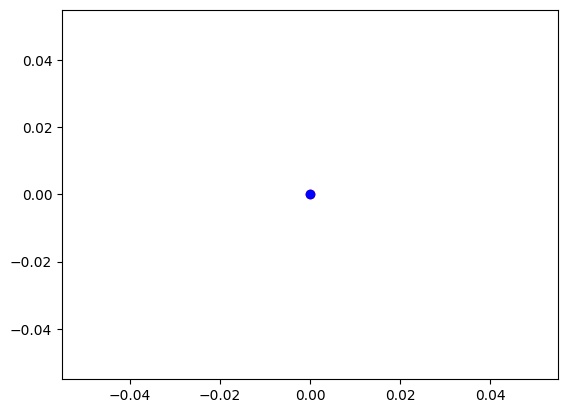

In [123]:
import matplotlib.pyplot as plt
x_label = list(range(len(LB_list)))
plt.scatter(x_label, UB_list, color = "r")
plt.scatter(x_label, LB_list, color = "b")#, marker = "*")
# UB_list
# LB_list

In [ ]:
plt.plot(LB_list)

In [ ]:
UB_list

In [160]:
def LDR_RO():
    m = gp.Model("LDR")
    x_type = GRB.CONTINUOUS
    x = m.addMVar(shape = (len(ind_x),), vtype = x_type)
    nv = m.addVar(vtype = GRB.CONTINUOUS, lb = 0)
    mu = m.addVar(vtype = GRB.CONTINUOUS)
    eta = m.addVar(vtype = GRB.CONTINUOUS)

    y_len = W.shape[1]
    u_len = M.shape[1]
    I = T.shape[0]
#    I = len(ind_T)
    D_len = D_set[0].shape[0]  ### the number of rows for uncertainty set constraints
    K = len(ind_k)# number of clusters

    theta = m.addMVar(shape = (K,), vtype = GRB.CONTINUOUS )
    gamma = m.addMVar(shape = (K,), vtype = GRB.CONTINUOUS, lb = 0)
    
    L = m.addMVar(shape = (y_len,u_len), vtype = GRB.CONTINUOUS)
    g = m.addMVar(shape = (y_len,), vtype = GRB.CONTINUOUS)
    xi = m.addMVar(shape = (I+1,D_len,K), vtype = GRB.CONTINUOUS, lb = 0) # shape of Xi is (I, D_len, K)

#    m.addConstr(A@x >= q)
    
    m.addConstr(mu + rho*nv +nv*(pbar@gamma) - eta <= 0)

    for k in ind_k:
        m.addGenConstrLog(gamma[k], theta[k])
        m.addConstr((theta[k]+1)*nv >= b@g + d_set[k]@xi[0,:,k] - mu ) 
        m.addConstr(D_set[k].T@xi[0,:,k] == L.T@b) 
        m.addConstrs(d_set[k]@xi[i+1,:,k] <= h[i] - T[i,:]@x - W[i,:]@g for i in range(I))
        m.addConstrs(D_set[k].T[j]@xi[i+1,:,k] == W[i,:]@L[:,j] + M[i,j] for j in ind_u for i in range(I) )
        # for i in range(1,I):
        #     m.addMConstr(D_vec[k].T, xi[i,:,k], "=", )

    m.setObjective(c@x + eta, GRB.MINIMIZE)
    m.setParam("OutputFlag", 0)   
    m.optimize()

    return m.objVal, x.x 

In [161]:
import time
str_time = time.time()
res, x_value = LDR_RO()
comp_time_AADP = time.time() - str_time
comp_time_AADP
print("objective value with LDR is: ", res)
print("optimal first stage decision is: ", x_value)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
objective value with LDR is:  250.32642574855544
optimal first stage decision is:  [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
  358.240998   1804.81807542 1831.83590606 1866.41740148 1846.86039837
 1851.97319993 1850.2061759  1890.68887673 1874.08267318 1923.3958854
    0.            3.16700809    0.            0.        ]


In [ ]:
dd_24